In [1]:
import pandas as pd
import numpy as np
import codecs

from matplotlib import pyplot as plt

from urllib import request

%matplotlib inline

# Dataset da FCPC

Base de dados de pagamentos a pessoas físicas da Fundação Cearense de Pesquisa e Cultura

fonte: http://www.fcpc.ufc.br/AcessoInformacao/PagamentoPessoaFisica

# Contando projetos

#### Python puro

In [2]:
with codecs.open("data/pagamentos_fisica_fcpc.csv", encoding='utf-8') as f:
    
    content = f.readlines()
    
content[:4]

['cpf,nome,tipo_pagamento,projeto,data,valor,filename\r\n',
 '***.000.103-**,REGILDA RODRIGUES DE SOUSA,ADIANTAMENTO PARA VIAGENS,2213 - CT - UFC/FCPC - PROJETO PROJOVEM CAMPO,2010-11-22,240.0,2010.csv\r\n',
 '***.000.103-**,REGILDA RODRIGUES DE SOUSA,ADIANTAMENTO PARA VIAGENS,2213 - CT - UFC/FCPC - PROJETO PROJOVEM CAMPO,2010-10-15,180.0,2010.csv\r\n',
 '***.000.103-**,REGILDA RODRIGUES DE SOUSA,ADIANTAMENTO PARA VIAGENS,2213 - CT - UFC/FCPC - PROJETO PROJOVEM CAMPO,2010-08-18,180.0,2010.csv\r\n']

In [3]:
projetos = [row.split(',')[3] for row in content]

In [4]:
list(set(projetos))[-3:]

['3035 - CT - UFC/FCPC-CASA AMARELA-CINEMA VIDEO E FOTOGRAFIA 2014.1',
 '2826 - CT - BNDES/FCPC-CRESCIMENTO ECONOMICOS',
 '2898 - CT - UFC/FCPC - MESTRADO PROFISSIONAL EM ECONOMIA D']

In [5]:
from collections import Counter

counts = Counter(projetos)

counts.most_common(5)

[('2924 - CT - UFC/FCPC - IMPLANTACAO E OFERTA DOS CURSOS DE GRADUACAO DA UAB/UFC 2012',
  13068),
 ('2619 - CT - UFC/FCPC - CURSOS DE GRADUACAO UAB - 5º E 6º SEMESTRES', 5284),
 ('2390 - CT - UFC/FCPC - OFERTA DOS CURSOS DE GRADUAÇÃO DA UAB 3º E 4º SEMESTRES',
  4760),
 ('2212 - CT - UFC/FCPC -ACOES REFERENTES AO 1º E 2º SEMESTRES', 4720),
 ('0101 - FCPC', 4591)]

#### Pandas

In [6]:
fcpc = pd.read_csv("data/pagamentos_fisica_fcpc.csv")

fcpc.head(3)

,cpf,nome,tipo_pagamento,projeto,data,valor,filename
0,***.000.103-**,REGILDA RODRIGUES DE SOUSA,ADIANTAMENTO PARA VIAGENS,2213 - CT - UFC/FCPC - PROJETO PROJOVEM CAMPO,2010-11-22,240.0,2010.csv
1,***.000.103-**,REGILDA RODRIGUES DE SOUSA,ADIANTAMENTO PARA VIAGENS,2213 - CT - UFC/FCPC - PROJETO PROJOVEM CAMPO,2010-10-15,180.0,2010.csv
2,***.000.103-**,REGILDA RODRIGUES DE SOUSA,ADIANTAMENTO PARA VIAGENS,2213 - CT - UFC/FCPC - PROJETO PROJOVEM CAMPO,2010-08-18,180.0,2010.csv


In [7]:
fcpc['data'] = pd.to_datetime(fcpc.data, format="%Y-%m-%d")

In [8]:
fcpc.describe().T

,count,mean,std,min,25%,50%,75%,max
valor,126680.0,1660.480522,3492.489457,0.0,177.0,400.0,2143.22,328428.65


In [9]:
fcpc.describe(include = ['O'])

,cpf,nome,tipo_pagamento,projeto,filename
count,126680,126680,126680,126679,126680
unique,16215,17623,12,916,8
top,***.501.533-**,FRANCISCO RODRIGO PORTO CAVALCANTI,ADIANTAMENTO PARA VIAGENS,2924 - CT - UFC/FCPC - IMPLANTACAO E OFERTA DO...,2014.csv
freq,259,259,43521,13068,22143


In [10]:
fcpc.tipo_pagamento.value_counts().nlargest(3)

ADIANTAMENTO PARA VIAGENS    43521
SERVIÇO PRESTADO - RPA       33432
FOLHA DE PAGAMENTO - CLT     25676
Name: tipo_pagamento, dtype: int64

In [11]:
largest_projetos = fcpc.groupby('projeto').valor.sum().nlargest(7) # maior soma de pagamentos
largest_projetos

projeto
0101 - FCPC                                                                            11295825.98
3098 - CT - FCPC/IPLANFOR - PLANO ESTRATÉGICO FORTALEZA 2040                            7373401.34
1089 - RESCISAO CONTRATUAL                                                              6617825.17
2924 - CT - UFC/FCPC - IMPLANTACAO E OFERTA DOS CURSOS DE GRADUACAO DA UAB/UFC 2012     6264561.69
2922 - CT - PETROBRAS - PROJETO AMBES                                                   5753658.23
3143 - TC - LG/UFC/FCPC - MOBILE, TOOLS & CAS                                           5697163.62
3022 - CT - UFC/FCPC - CURSO DE ESPECIALIZAÇÃO EM SAUDE DA FAMILIA                      3326654.89
Name: valor, dtype: float64

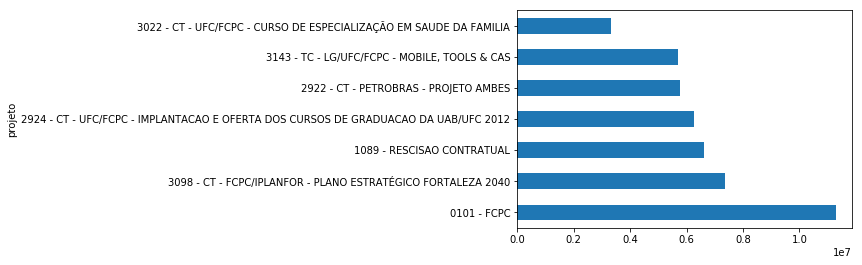

In [12]:
largest_projetos.plot(kind='barh')

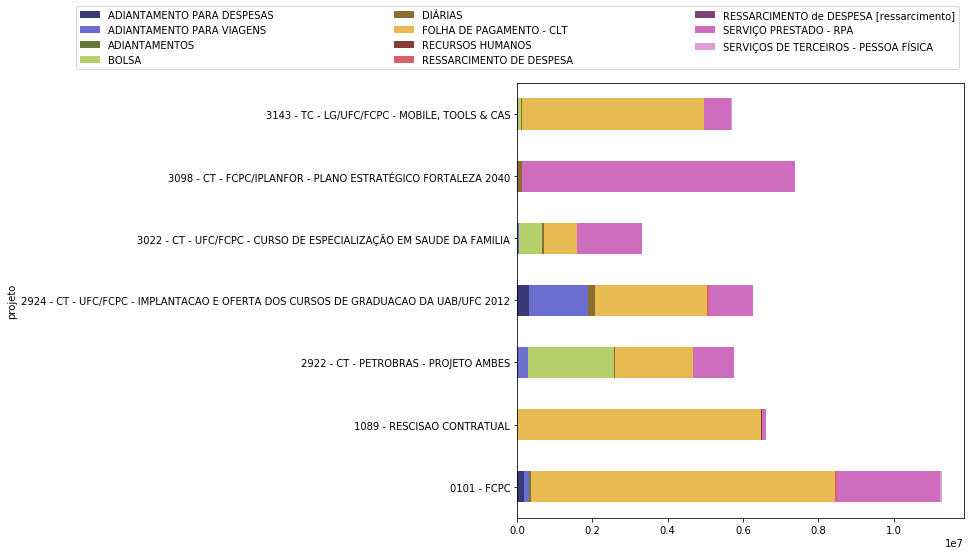

In [13]:
fcpc[fcpc.projeto.isin(largest_projetos.index)].groupby(['projeto', 'tipo_pagamento']).valor.sum().unstack()\
.plot(kind = 'barh', stacked = True, figsize = (8, 8), cmap=plt.cm.Vega20b)

plt.legend(bbox_to_anchor = (-1., 1.02, 2., .102), ncol = 3, mode = "expand", loc = 3)


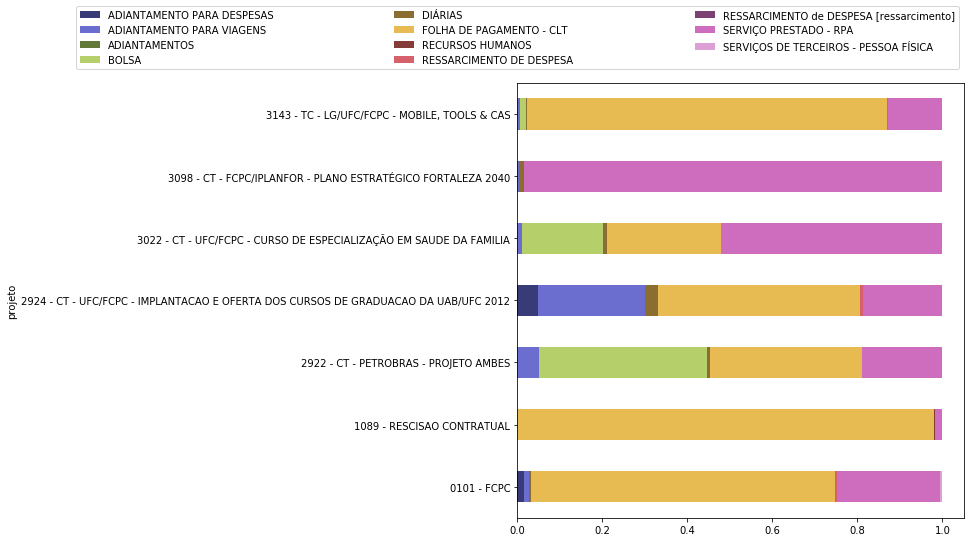

In [14]:
count_subset = fcpc[fcpc.projeto.isin(largest_projetos.index)].groupby(['projeto', 'tipo_pagamento']).valor.sum().unstack()
normed_subset = count_subset.div(count_subset.sum(axis = 1), axis = 0)

normed_subset.plot(kind = 'barh', stacked = True, figsize = (8, 8), cmap=plt.cm.Vega20b)

plt.legend(bbox_to_anchor = (-1., 1.02, 2., .102), ncol = 3, mode = "expand", loc = 3)

# Dataset de servidores da UFC

Dataset gerado a partir dos dados de cadastro e de remuneração de servidores públicos federais, de fevereirod de 2017.

Fonte: http://portaldatransparencia.gov.br/downloads/servidores.asp

Consulta por servidor: http://portaldatransparencia.gov.br/servidores/Servidor-ListaServidores.asp

In [15]:
ufc = pd.read_csv("data/remuneracao_ufc_20170228.csv", decimal=",")

In [16]:
ufc[ufc.nome == 'DANILO LEAL MACIEL'].T

,3238
cargo,ANALISTA DE TEC DA INFORMACAO
funcao,NaN
uorg_lotacao,DIVISAO DE SISTEMAS DE INFORMACAO
uorg_exercicio,DIVISAO DE SISTEMAS DE INFORMACAO
org_lotacao,UNIVERSIDADE FEDERAL DO CEARA
org_exercicio,UNIVERSIDADE FEDERAL DO CEARA
jornada,40 HORAS SEMANAIS
remuneracao_basica_bruta,6354.6
remuneracao_pos_deducao,5054.57
nome,DANILO LEAL MACIEL


In [17]:
def calcula_concentracao_funcao(grupo):
    
    funcoes = grupo.groupby('funcao').size()
    funcoes['n_funcoes'] = funcoes.sum()
    funcoes['n_servidores'] = len(grupo.nome.unique())
    funcoes['proporcao'] = funcoes.n_funcoes/funcoes.n_servidores
    
    return funcoes

conf = ufc.groupby('uorg_exercicio').apply(calcula_concentracao_funcao).unstack().fillna(0)

conf[conf.n_servidores > 10].sort_values("proporcao", ascending=False).head()

funcao,CARGO DE DIRECAO - CD - IFES,DIRECAO E ASSESSORAMENTO SUPERIOR,FUNCAO COMISSIONADA DE COORD. CURSO,FUNCAO GRATIFICADA - IFES,n_funcoes,n_servidores,proporcao
uorg_exercicio,,,,,,,
NUCLEO DE GESTAO,0.0,0.0,0.0,15.0,15.0,15.0,1.000000
DIVISAO DE REDES DE COMPUTADORES,0.0,0.0,0.0,5.0,5.0,14.0,0.357143
CENTRO DE HUMANIDADES,1.0,0.0,0.0,2.0,3.0,11.0,0.272727
CENTRO DE TECNOLOGIA,1.0,0.0,0.0,2.0,3.0,12.0,0.250000
DIVISAO DE INFORMACAO DE PESSOAL ATIVO,0.0,0.0,0.0,3.0,3.0,13.0,0.230769


In [18]:
conf.loc['DIVISAO DE SISTEMAS DE INFORMACAO']

funcao
CARGO DE  DIRECAO - CD - IFES           0.000000
DIRECAO E ASSESSORAMENTO SUPERIOR       0.000000
FUNCAO COMISSIONADA DE COORD. CURSO     0.000000
FUNCAO GRATIFICADA - IFES               1.000000
n_funcoes                               1.000000
n_servidores                           46.000000
proporcao                               0.021739
Name: DIVISAO DE SISTEMAS DE INFORMACAO, dtype: float64

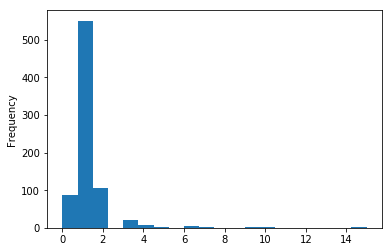

In [19]:
conf.n_funcoes.plot(kind='hist', bins=20)

In [20]:
# mantenho apenas um vínculo por servidor
ufc = ufc.drop_duplicates("nome")

In [21]:
ufc.nlargest(5, "remuneracao_basica_bruta", keep="first")[['remuneracao_basica_bruta', 'nome']]

,remuneracao_basica_bruta,nome
1972,44341.22,LUIZ BOTELHO ALBUQUERQUE
6438,43824.33,SEBASTIAO CARNEIRO DE ALMEIDA
2031,43535.89,HENRY DE HOLANDA CAMPOS
4688,42643.56,CARLOS AUGUSTO ALENCAR JUNIOR
1923,40946.95,BOANERGES FREIRE DE AQUINO


In [22]:
ufc.uorg_lotacao.value_counts().describe()

count    527.000000
mean      11.732448
std       39.898523
min        1.000000
25%        1.000000
50%        3.000000
75%        8.000000
max      734.000000
Name: uorg_lotacao, dtype: float64

In [23]:
ufc.uorg_lotacao.value_counts().loc[lambda x: x < 2].shape

(165,)

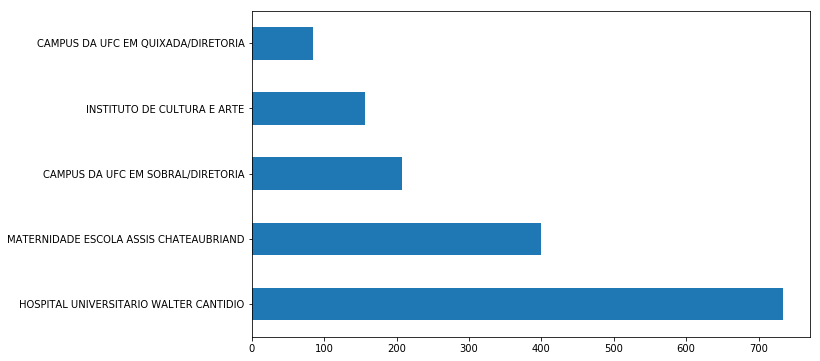

In [24]:
ufc.uorg_lotacao.value_counts().nlargest(5).plot(kind='barh', figsize=(10, 6))

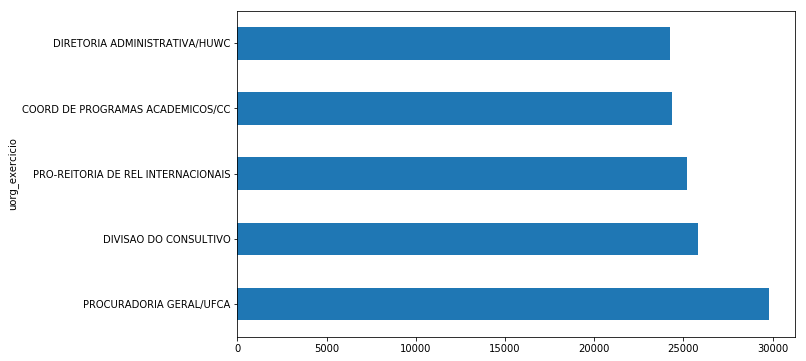

In [25]:
ufc.groupby("uorg_exercicio").remuneracao_basica_bruta.mean().nlargest(5).plot(kind='barh', figsize=(10, 6))

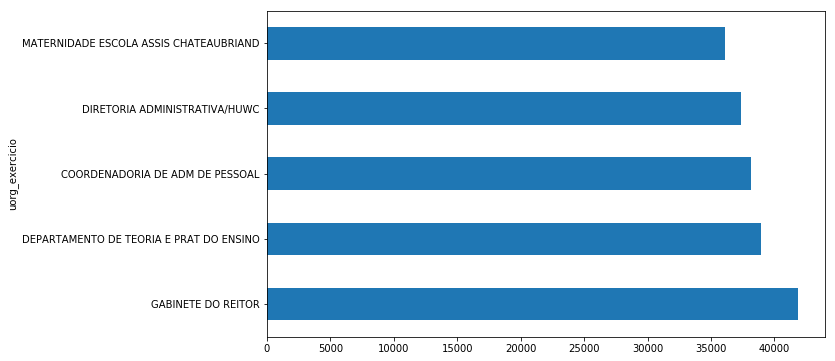

In [26]:
ufc.groupby("uorg_exercicio").remuneracao_basica_bruta.apply(lambda g: g.max() - g.min()).nlargest(5).plot(kind='barh', figsize=(10, 6))

In [27]:
ufc[ufc.uorg_exercicio == 'GABINETE DO REITOR']\
.loc[lambda x: [x.remuneracao_basica_bruta.argmax(), x.remuneracao_basica_bruta.argmin()]]

,cargo,funcao,uorg_lotacao,uorg_exercicio,org_lotacao,org_exercicio,jornada,remuneracao_basica_bruta,remuneracao_pos_deducao,nome
6438,PROFESSOR DO MAGISTERIO SUPERIOR,NaN,NaN,GABINETE DO REITOR,UNIVERSIDADE FEDERAL DO CEARA,UNIVERSIDADE FEDERAL DO CEARA,DEDICACAO EXCLUSIVA,43824.33,30163.89,SEBASTIAO CARNEIRO DE ALMEIDA
7340,LOCUTOR,NaN,GABINETE DO REITOR,GABINETE DO REITOR,UNIVERSIDADE FEDERAL DO CEARA,UNIVERSIDADE FEDERAL DO CEARA,40 HORAS SEMANAIS,1945.07,2010.33,PEDRO VITOR GADELHA MENDES


In [28]:
df = pd.merge(ufc, fcpc, left_on = "nome", right_on = "nome", how = "outer", indicator = True)

In [29]:
df.shape

(131611, 17)

In [30]:
df._merge.value_counts()

right_only    112095
both           14585
left_only       4931
Name: _merge, dtype: int64

In [31]:
fcpcufc = df[df._merge == "both"]

In [32]:
fcpcufc.groupby("nome").valor.sum().nlargest(5)

nome
JAVAM DE CASTRO MACHADO               802283.12
LUIZ ROBERTO DE OLIVEIRA              665245.29
FRANCISCO RODRIGO PORTO CAVALCANTI    606908.99
ROSSANA MARIA DE CASTRO ANDRADE       594043.50
HELANO DE SOUSA CASTRO                579292.22
Name: valor, dtype: float64

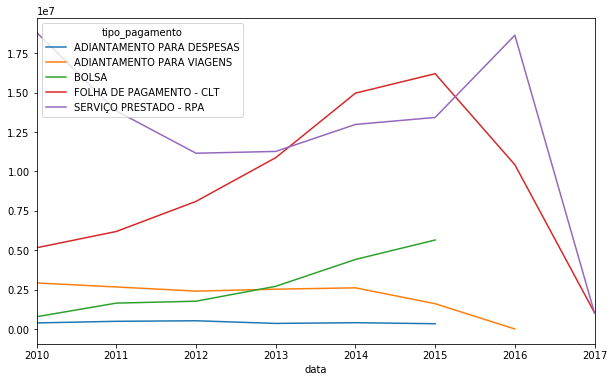

In [33]:
top_5_pagamentos = fcpc.tipo_pagamento.value_counts().nlargest(5)

fcpc[fcpc.tipo_pagamento.isin(top_5_pagamentos.index)].pivot_table("valor", fcpc.data.dt.year, "tipo_pagamento", aggfunc="sum")\
.plot(figsize = (10, 6))

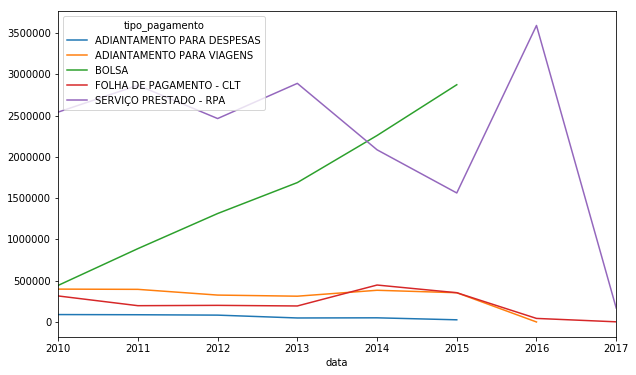

In [34]:
top_5_pagamentos = fcpcufc.tipo_pagamento.value_counts().nlargest(5)

fcpcufc[fcpcufc.tipo_pagamento.isin(top_5_pagamentos.index)].pivot_table("valor", fcpcufc.data.dt.year, "tipo_pagamento", aggfunc="sum")\
.plot(figsize = (10, 6))